# Analysis

Collect results of a given experiment and summarize in standardized dataframe.

In [1]:
import pandas as pd
from aaai20.io import filename_results

import matplotlib.style as style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

from aaai20.io import (
    build_filesystem,
    default_prefix_exp_fn_suffix,
    filename_config,
    filename_cli_commands,
    filename_script,
    filename_logs,
    exp_directory
)

from aaai20.cmd_gen import (
    all_fnames_in_dir,
    generate_config_and_log_fname,
    generate_df_commands,
    extract_idx_from_fnames,
    default_start_idx,
    prepare_fs,
)

import os

In [2]:
def convert_json_to_df(fn):
    exp_idx = pd.read_json(fn, typ='series').exp_idx
    predict_config = pd.read_json(fn, typ='series').predict_config

    for k in predict_config:
        predict_config[k] = [predict_config[k]]

    df = pd.DataFrame()
    df = df.from_dict(predict_config)
    df['exp_idx'] = exp_idx
    
    return df
    

In [3]:
def collect_results_in_directory(exp_keyword=None, script=None, add_config=True):
    # Obtain correct exp directory
    d = exp_directory(exp_dname=exp_keyword, script=script, fs=None)

    dn_res = d.get("results")
    dn_tmg = d.get("timings")
    dn_cfg = d.get("config")

    # Collect results
    fn_res = [os.path.relpath(os.path.join(dn_res, f)) for f in os.listdir(dn_res)]
    fn_res.sort()

    df_res = pd.concat([pd.read_csv(fn) for fn in fn_res])

    # Collect timings
    fn_tmg = [os.path.relpath(os.path.join(dn_tmg, f)) for f in os.listdir(dn_tmg)]
    fn_tmg.sort()

    df_tmg = pd.concat([pd.read_csv(fn) for fn in fn_tmg])
    
    # Collect configs
    fn_cfg = [os.path.relpath(os.path.join(dn_cfg, f)) for f in os.listdir(dn_cfg)]
    fn_cfg.sort()

    df_cfg = pd.concat([convert_json_to_df(fn) for fn in fn_cfg])

    # Join
    df = df_res.copy()
    df[df_tmg.columns] = df_tmg[df_tmg.columns]

    if add_config:
        df = pd.merge(left=df, right=df_cfg, left_on="exp_idx", right_on="exp_idx")

    # Save in proper location
    fn = os.path.join(d["current_exp"], "out.csv")
    df.to_csv(fn, index=False)

    return df

In [20]:
def plot(dfs):

    df = pd.concat(dfs)
    df_plot = df[['dataset', 'f1_macro', 'difficulty', 'identifier']].groupby(by=['identifier', 'difficulty']).mean()

    # Visuals
    identifiers = df_plot.index.levels[0].unique().values.tolist()

    x = df_plot.index.levels[1].values.tolist()

    y = dict()
    labels = []

    fig=plt.figure(figsize=(12, 8))
    for trace in identifiers:
        y[trace] = df_plot.loc[trace].values
        plt.plot(x, y[trace])
        labels.append(trace)


    plt.legend(labels, loc='lower left')
    plt.show()
    return

In [5]:
script = 'run_pxs'
exp_keyword = 'predict-pxs'

In [6]:
df_pxs = collect_results_in_directory(exp_keyword='predict-pxs', script='run_pxs')

In [7]:
df_pxs.head(10)

,missing_percentage,difficulty,q_idx,f1_micro,f1_macro,identifier,dataset,exp_idx,ind_time,inf_time,inferce_algorithm,inference_algorithm
0,0.000000,0,0,0.991379,0.497835,predict-pxs,tretail,2,133.582461,3.820815,EPIS_sampling,EPIS_sampling
1,0.096296,1,1,0.991379,0.497835,predict-pxs,tretail,2,133.582461,4.028184,EPIS_sampling,EPIS_sampling
2,0.192593,2,2,0.991379,0.497835,predict-pxs,tretail,2,133.582461,3.625180,EPIS_sampling,EPIS_sampling
3,0.296296,3,3,0.991379,0.497835,predict-pxs,tretail,2,133.582461,3.027356,EPIS_sampling,EPIS_sampling
4,0.392593,4,4,0.991379,0.497835,predict-pxs,tretail,2,133.582461,3.705975,EPIS_sampling,EPIS_sampling
5,0.496296,5,5,0.991379,0.497835,predict-pxs,tretail,2,133.582461,2.861299,EPIS_sampling,EPIS_sampling
6,0.592593,6,6,0.991379,0.497835,predict-pxs,tretail,2,133.582461,1.413292,EPIS_sampling,EPIS_sampling
7,0.688889,7,7,0.991379,0.497835,predict-pxs,tretail,2,133.582461,2.226285,EPIS_sampling,EPIS_sampling
8,0.792593,8,8,0.991379,0.497835,predict-pxs,tretail,2,133.582461,2.879903,EPIS_sampling,EPIS_sampling
9,0.888889,9,9,0.991379,0.497835,predict-pxs,tretail,2,133.582461,2.426145,EPIS_sampling,EPIS_sampling


In [17]:
df_mercs = collect_results_in_directory(exp_keyword='md8-random-final', script='run_mercs', add_config=True)
df_mercs_2 = collect_results_in_directory(exp_keyword='md8-base-final', script='run_mercs', add_config=True)

/cw/dtaijupiter/NoCsBack/dtai/elia/00_Software/anaconda/envs/aaai20/lib/python3.7/site-packages/ipykernel_launcher.py:25: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [18]:
df_pxs['identifier'] = df_pxs['inference_algorithm']
df_mercs['identifier'] += df_mercs['prediction_algorithm']
df_mercs_2['identifier'] += df_mercs_2['prediction_algorithm']

/cw/dtaijupiter/NoCsBack/dtai/elia/00_Software/anaconda/envs/aaai20/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


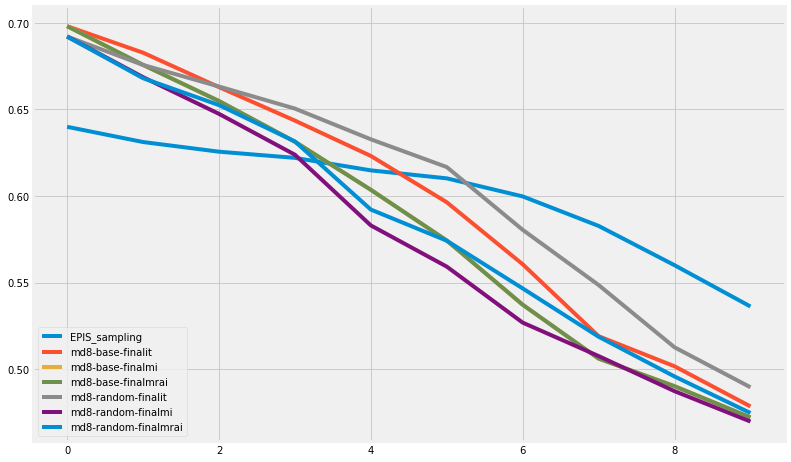

In [21]:
dfs = [df_pxs, df_mercs, df_mercs_2]
plot(dfs)

# Collect configs

In [11]:
exp_keyword='mercs-basic-SL'
script='run_mercs'

d = exp_directory(exp_dname=exp_keyword, script=script, fs=None)

dn_res = d.get('results')
dn_tmg = d.get('timings')
dn_cfg = d.get('config')

In [12]:
dn_cfg

'/cw/dtaijupiter/NoCsBack/dtai/elia/aaai20/out/run_mercs/mercs-basic-SL/config'

In [13]:
# Collect configs
fn_cfg = [os.path.relpath(os.path.join(dn_cfg, f)) for f in os.listdir(dn_cfg)]
fn_cfg.sort()

df_cfg = pd.concat([convert_json_to_df(fn) for fn in fn_cfg])

FileNotFoundError: [Errno 2] No such file or directory: '/cw/dtaijupiter/NoCsBack/dtai/elia/aaai20/out/run_mercs/mercs-basic-SL/config'

In [22]:
df_cfg.head()

NameError: name 'df_cfg' is not defined

In [24]:
tuple([1,2,3])

(1, 2, 3)

TypeError: 'int' object is not iterable

In [ ]:
df_merge